### Скользящее окно от Марины

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

from zipfile import ZipFile

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [2]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import get_mse
from utils.figures import get_all_sensors_plot, get_signals_comparison_plot, get_free_movements_plot

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [3]:
import sys
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['free_movements', 'gestures_protocol', 'gestures_test', 'gestures_train'])

In [4]:
# read train from zip in data folder
with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    gestures_train = pd.read_csv(myzip.open('gestures_train.csv'), index_col=0)
print(gestures_train.shape)
gestures_train.head()

(33172, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,1605,0,1739,94,6,2618,30,29,2058,40,...,-1,19,25,22,11,0,0,1000,0,6492378
1,1604,8,1738,94,7,2618,30,28,2062,40,...,-14,19,25,21,11,0,0,1000,0,6492411
2,1607,9,1739,94,7,2624,32,28,2064,43,...,-17,19,25,21,11,0,0,1000,0,6492444
3,1597,2,1743,93,5,2612,31,31,2052,39,...,-15,19,25,21,11,0,0,1000,0,6492477
4,1595,7,1722,91,8,2603,32,26,2052,37,...,-10,19,25,21,11,0,0,1000,0,6492510


In [5]:
# read test from zip in data folder

gestures_test =  mounts['gestures_test']
print(gestures_test.shape)
gestures_test.head()

(8168, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
33172,1469,11,1858,99,4,2552,29,39,2190,38,...,-3,9,12,4,1,0,0,1000,433,7587054
33173,1460,11,1857,99,6,2549,31,32,2190,41,...,-3,9,12,4,1,0,0,1000,433,7587087
33174,1471,9,1860,101,6,2554,29,35,2193,39,...,-6,10,12,4,1,0,0,1000,433,7587120
33175,1467,8,1856,98,0,2549,27,36,2190,40,...,-12,10,12,4,1,0,0,1000,433,7587153
33176,1471,6,1859,99,3,2554,28,36,2187,40,...,-19,10,12,4,1,0,0,1000,433,7587186


# Preprocessing

In [6]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']  # , 'ENC5' - only 5 features
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
TR_TIME = gestures_train.shape[0]  # time of train data
TS_TIME = gestures_test.shape[0]  # time of test data
n_frame = 3  # number of time ticks in "sliding window" 
SENS = len(OMG_CH)   # sensors number
FN = len(OMG_CH) + len(ACC_CH) + len(GYR_CH)   # features number
TN = len(GLOVE_CH)   # target values number
RANDOM_STATE = 32
 
assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH)+1 == gestures_train.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")
print(f"time: train {TR_TIME} , test {TS_TIME}")
print(f"number of:  sensors {SENS},  features {FN} , target values {TN}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']
time: train 33172 , test 8168
number of:  sensors 50,  features 56 , target values 5


In [7]:
# делаем скользящее окно из n_frame слоев: 
# отрезаем n_frame-1 временной тик в начале ряда (у датчиков и у таргета сразу), 
#     т.к. для них нет нужного кол-ва предыдущих тиков, 
# добавляем третье измерение для подстановки предыдущих временных тиков, 
# решейпим обратно в двумерный массив, получая вместо 50 датчиков 150 значений по шаблону 
#     sens1.t sens1.t-1 sens1.t-2 sens2.t sens2.t-1 sens2.t-2 ....
X_train = np.array([gestures_train.iloc[n_frame-i-1:TR_TIME-i, 0:SENS] 
                    for i in range(n_frame)]).transpose((1,2,0)).reshape((TR_TIME-n_frame+1, SENS*n_frame))
X_test = np.array([gestures_test.iloc[n_frame-i-1:TS_TIME-i, 0:SENS] 
                   for i in range(n_frame)]).transpose((1,2,0)).reshape((TS_TIME-n_frame+1, SENS*n_frame))
y_train = np.array(gestures_train.iloc[n_frame-1:, FN:FN+TN])
y_test = np.array(gestures_test.iloc[n_frame-1:, FN:FN+TN])

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33170, 150), (8166, 150), (33170, 5), (8166, 5))

# Modeling

In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=20,  random_state=RANDOM_STATE) #max_depth=10,
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=32)

## Prediction

In [11]:
y_pred_train = model.predict(X_train)
y_df_train = pd.DataFrame(y_train, columns=GLOVE_CH, index=gestures_train.loc[n_frame - 1:, 'ts'])
y_df_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train.loc[n_frame - 1:, 'ts'])

y_pred_test = model.predict(X_test)
y_df_test = pd.DataFrame(y_test, columns=GLOVE_CH, index=gestures_test.loc[TR_TIME + n_frame - 1:, 'ts'])
y_df_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test.loc[TR_TIME + n_frame - 1:, 'ts'])

## Metrics

In [12]:
from sklearn.metrics import mean_squared_error as mse

metrics_train = {col : mse(y_df_train[col], y_df_pred_train[col]) for col in GLOVE_CH}
metrics_test = {col : mse(y_df_test[col], y_df_pred_test[col]) for col in GLOVE_CH}

metrics_train = pd.Series(metrics_train)
metrics_test = pd.Series(metrics_test)

print('Train')
display(metrics_train)
print('Test')
display(metrics_test)

Train


ENC0    1.234426
ENC1    1.076190
ENC2    1.299275
ENC3    4.388262
ENC4    7.440666
dtype: float64

Test


ENC0     47.537624
ENC1     44.755539
ENC2     35.780515
ENC3    145.050910
ENC4    404.581561
dtype: float64

## Optuna

In [ ]:
import optuna
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from optuna.samplers import TPESampler

# 4. initiate random seed in Optuna
sampler = TPESampler(seed=RANDOM_STATE) # fix random seed

In [ ]:
def optuna_gbr(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 40, 250, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.99)
    min_samples_leaf = trial.suggest_int('max_depth', 2, 15, 1)
   
    # model creation 
    model = MultiOutputRegressor(GradientBoostingRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators, 
        max_features='auto',
        min_samples_leaf = min_samples_leaf,
        learning_rate=learning_rate,
        random_state=RANDOM_STATE)
    )
    
    # training
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse_score = mean_squared_error(y_test, y_pred)

    return mse_score 

In [ ]:
# create study set
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize", sampler=sampler)
# try multiple times
study.optimize(optuna_gbr, n_trials=10)

clear_output(wait=False)

optuna.visualization.plot_optimization_history(study, target_name="mean_squared_error")

[I 2023-05-06 19:44:58,380] A new study created in memory with name: GradientBoostingRegressor
[W 2023-05-06 19:56:31,363] Trial 0 failed with parameters: {'n_estimators': 221, 'max_depth': 7, 'learning_rate': 0.5540262024386248} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Lena\AppData\Local\Temp\ipykernel_2524\83269897.py", line 19, in optuna_gbr
    model.fit(X_train, y_train)
  File "C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\sklearn\multioutput.py", line 216, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\j

KeyboardInterrupt: 

In [ ]:
model = MultiOutputRegressor(GradientBoostingRegressor(
        max_depth=8,
        n_estimators=150, 
        max_features='auto',
        min_samples_leaf = 3,
        learning_rate=0.8,
        random_state=RANDOM_STATE)
)

# training
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.8,
                                                         max_depth=8,
                                                         max_features='auto',
                                                         min_samples_leaf=3,
                                                         n_estimators=150,
                                                         random_state=32))

In [ ]:
y_pred_train = model.predict(X_train)
y_df_train = pd.DataFrame(y_train, columns=GLOVE_CH, index=gestures_train.loc[n_frame - 1:, 'ts'])
y_df_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train.loc[n_frame - 1:, 'ts'])

y_pred_test = model.predict(X_test)
y_df_test = pd.DataFrame(y_test, columns=GLOVE_CH, index=gestures_test.loc[TR_TIME + n_frame - 1:, 'ts'])
y_df_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test.loc[TR_TIME + n_frame - 1:, 'ts'])

In [ ]:
metrics_train = {col : mse(y_df_train[col], y_df_pred_train[col]) for col in GLOVE_CH}
metrics_test = {col : mse(y_df_test[col], y_df_pred_test[col]) for col in GLOVE_CH}

metrics_train = pd.Series(metrics_train)
metrics_test = pd.Series(metrics_test)

print('Train')
display(metrics_train)
print('Test')
display(metrics_test)

Train


ENC0    0.099393
ENC1    0.117475
ENC2    0.143648
ENC3    0.272449
ENC4    0.928579
dtype: float64

Test


ENC0     43.291791
ENC1     44.655467
ENC2     65.026599
ENC3    296.176246
ENC4    773.843668
dtype: float64

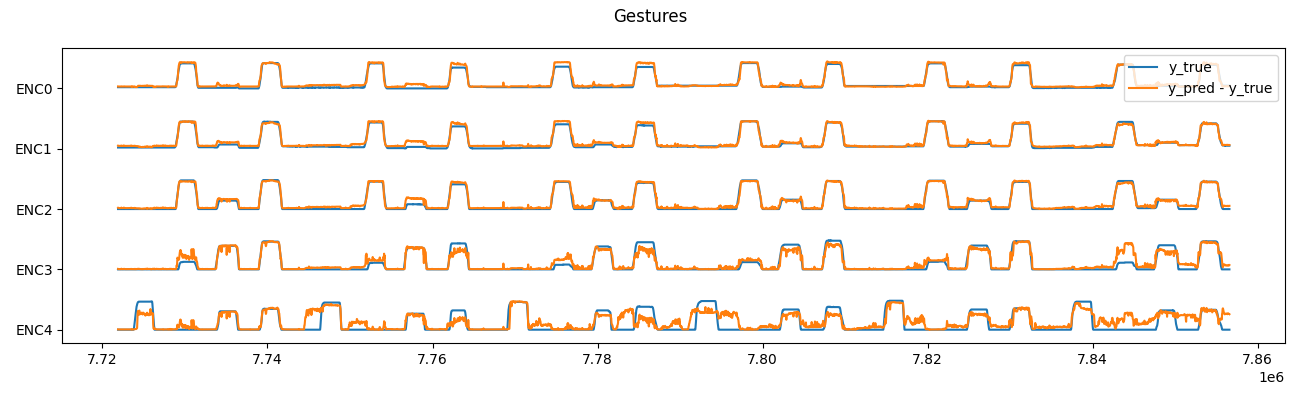

In [ ]:
# вторая половина теста
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200
start = int(TS_TIME/2)

p = plt.plot(gestures_test.loc[TR_TIME + n_frame - 1 + start:, 'ts'].values, y_test[start:] + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_test.loc[TR_TIME + n_frame - 1 + start:, 'ts'].values, y_pred_test[start:] + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred - y_true']

# for i in range(1, 8):
#     plt.axvline(gestures_test.loc[TR_TIME + n_frame - 1, 'ts'] + i * 30000, color='k')

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

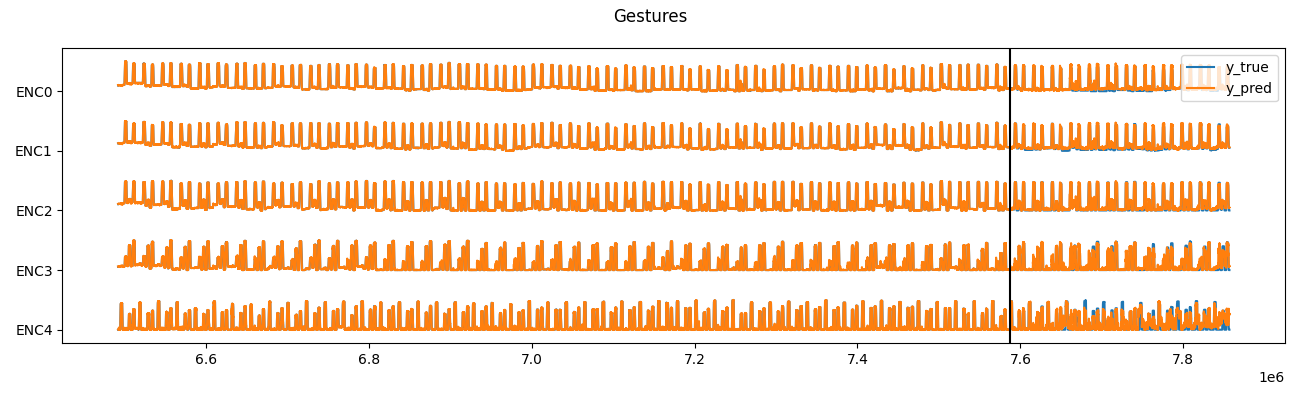

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_train.loc[n_frame - 1:, 'ts'].values, y_train + yticks, c='C0')
plt.plot(gestures_test.loc[TR_TIME + n_frame - 1:, 'ts'].values, y_test + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_train.loc[n_frame - 1:, 'ts'].values, y_pred_train + yticks, c='C1', linestyle='-')
plt.plot(gestures_test.loc[TR_TIME + n_frame - 1:, 'ts'].values, y_pred_test + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.axvline(gestures_train.loc[n_frame - 1:, 'ts'].values[-1], color='k')

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

# Real-time inference